In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import torch

### Defining Transforms 
Resize → model compatibility

Augmentation → generalization

Normalization → stable training

In [2]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


In [3]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


`- Note that only "training" is agumented, while "validation/test" is only resize and normalized.`

### Loading Dataset

In [4]:
from torchvision.datasets import ImageFolder

data_dir = "data"

full_dataset = ImageFolder(
    root=data_dir,
    transform=train_transform  # temporary, will change later
)

print("Classes:", full_dataset.classes)
print("Number of images:", len(full_dataset))


Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
Number of images: 4000


### Train/Validation Split

In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size]
)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


### Creating DataLoaders

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False, # Avoids Learning order bias
    num_workers=4, # For faster loading
    pin_memory=True # For faster GPU transfer
)


### Pre-training Sanity Check

In [7]:
import torch

images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


### Class Balance Check

In [8]:
from collections import Counter

labels = [label for _, label in full_dataset]
class_counts = Counter(labels)

for cls, count in class_counts.items():
    print(f"{full_dataset.classes[cls]}: {count}")


Anthracnose: 500
Bacterial Canker: 500
Cutting Weevil: 500
Die Back: 500
Gall Midge: 500
Healthy: 500
Powdery Mildew: 500
Sooty Mould: 500


### Baseline CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # -------- Feature extractor --------
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [10]:
from torchvision import models

def get_model(num_classes):
    model = models.resnet18(weights="IMAGENET1K_V1")

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [ ]:
import torch.optim as optim
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(full_dataset.classes)
model = PlantDiseaseCNN(num_classes).to(device)  # Or use get_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 10
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 3.0587 | Train Acc: 0.5747 | Val Loss: 0.4865 | Val Acc: 0.8363
Epoch 2/10 | Train Loss: 0.6121 | Train Acc: 0.7919 | Val Loss: 0.4459 | Val Acc: 0.8600
Epoch 3/10 | Train Loss: 0.4785 | Train Acc: 0.8381 | Val Loss: 0.2714 | Val Acc: 0.9163
Epoch 4/10 | Train Loss: 0.3801 | Train Acc: 0.8662 | Val Loss: 0.4293 | Val Acc: 0.8662
Epoch 5/10 | Train Loss: 0.3335 | Train Acc: 0.8853 | Val Loss: 0.1566 | Val Acc: 0.9413
Epoch 6/10 | Train Loss: 0.3838 | Train Acc: 0.8775 | Val Loss: 0.3792 | Val Acc: 0.8725
Epoch 7/10 | Train Loss: 0.3334 | Train Acc: 0.8875 | Val Loss: 0.1906 | Val Acc: 0.9263
Epoch 8/10 | Train Loss: 0.3124 | Train Acc: 0.8906 | Val Loss: 0.1840 | Val Acc: 0.9400
Epoch 9/10 | Train Loss: 0.2475 | Train Acc: 0.9241 | Val Loss: 0.1273 | Val Acc: 0.9613
Epoch 10/10 | Train Loss: 0.1981 | Train Acc: 0.9325 | Val Loss: 0.2657 | Val Acc: 0.9163


### Visualize Training and Validation Curves

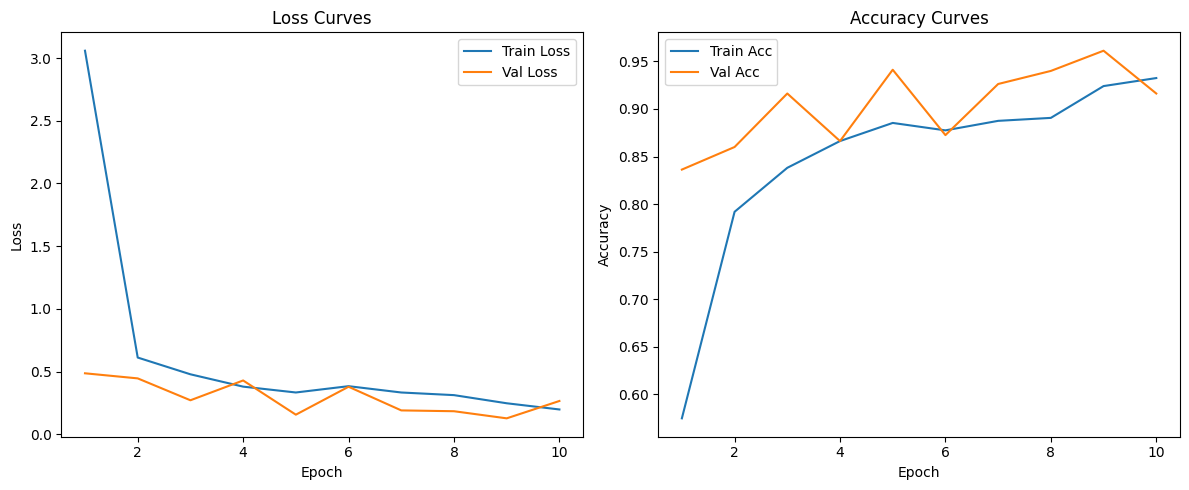

In [14]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate Best Model and Show Sample Predictions

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        95
           1       0.95      0.99      0.97       110
           2       0.97      0.98      0.98       112
           3       0.99      0.99      0.99        97
           4       0.88      0.95      0.91        79
           5       1.00      0.96      0.98        96
           6       0.98      0.91      0.94        97
           7       0.96      0.92      0.94       114

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800

Confusion Matrix:
 [[ 94   0   0   1   0   0   0   0]
 [  1 109   0   0   0   0   0   0]
 [  2   0 110   0   0   0   0   0]
 [  0   1   0  96   0   0   0   0]
 [  2   2   0   0  75   0   0   0]
 [  0   0   2   0   2  92   0   0]
 [  0   0   1   0   4   0  88   4]
 [  0   3   0   0   4   0   2 105]]


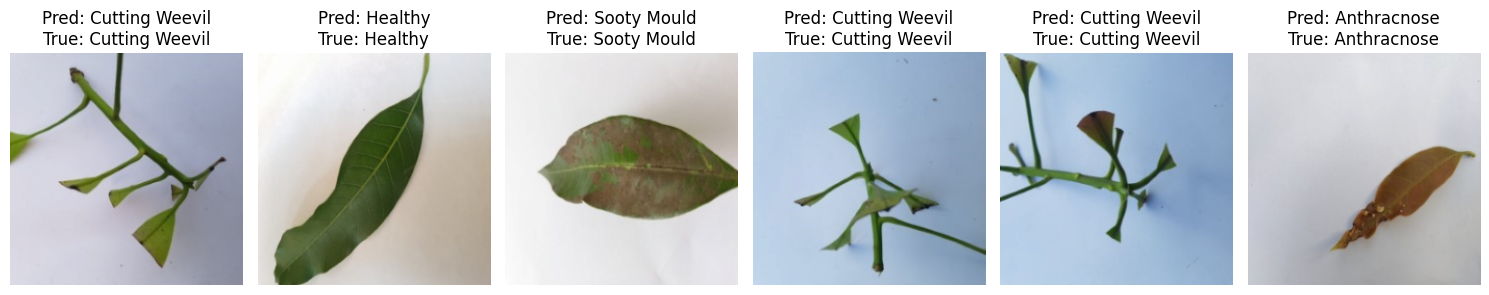

In [15]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
evaluate(model, val_loader, device)  # Print classification report and confusion matrix
import random
def show_sample_predictions(model, dataloader, class_names, device, num_samples=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                img = images[i].cpu().numpy().transpose(1,2,0)
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_samples, images_shown+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                images_shown += 1
            if images_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()
# Show predictions on validation set
show_sample_predictions(model, val_loader, full_dataset.classes, device)

### Inference on a Custom Image

In [ ]:
from PIL import Image
def predict_image(model, image_path, transform, class_names, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_t)
        pred = torch.argmax(output, dim=1).item()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred]}")
    plt.show()
    print(f"Predicted class: {class_names[pred]}")
# Example usage:
# predict_image(model, 'path/to/your/photo.jpg', val_transform, full_dataset.classes, device)